In [ ]:
# pip install factor_analyzer
# !pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
# conda install -c conda-forge scikit-learn-extra

In [547]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
import sklearn.datasets
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_samples, silhouette_score
from operator import itemgetter
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

## Dataset Creation
The primary dataframe we will be working with is df_fct, which is a dataframe composed of only the 36 factor variables.

In [548]:
# Create dataframe from customer_data file
df = pd.read_csv('customer_data.csv')

# Create dataframe of factors only
df_fct =  df.drop(['UID','Const'], axis=1)

# Number of variables/factors/stimuli
variables_to_examine = len(df_fct.columns)

## Factor Analysis

The variables are all on a similar scale, so we will use the covariance matrix for identifying principal components.

In [549]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=variables_to_examine, rotation=None)
fa.fit(df_fct)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()

# Create FactorAnalyzer object
n_factors = sum(i >= 1 for i in ev)
fa = FactorAnalyzer(n_factors=n_factors, rotation=None)

# Fit factor analysis model to variables
fa.fit(df_fct)

# Scores for the factor analysis, converted to dataframe
scores = pd.DataFrame(fa.transform(df_fct))


##############
# Extra Stuff
##############

# The loadings are the coefficients that make up the linear combination of original variables to get the factors (v1 = l1x1 + l2X2)
loadings = fa.loadings_

# Create dataframe of eigenvalues of the covariance matrix

data = {'factor'                    : range(1,n_factors+1),
        'eigenvalues'               : fa.get_eigenvalues()[0][0:n_factors],
        'common_factor_eigenvalues' : fa.get_eigenvalues()[1][0:n_factors],
        'variance'                  : fa.get_factor_variance()[0],
        'proportional_variance'     : fa.get_factor_variance()[1],
        'cumulative_variance'       : fa.get_factor_variance()[2]
       }

cov_matrix_eigenvals = pd.DataFrame(data=data).set_index('factor')

### Clustering

In [550]:
sw=[]

for i in range(2,7):
    
    # Create clustering objects
    cls1 = KMeans(n_clusters=i, random_state=0)
    cls2 = KMedoids(n_clusters=i, random_state=0)
    cls3 = AgglomerativeClustering(n_clusters=i, affinity = 'euclidean', linkage ='ward') #if linkage is ward, affinity must be Euclidean
    cls_algs = [['kMeans', cls1], ['kMedoids', cls2], ['Hierarchical', cls3]]
    
    # Fit and score clustering solutions for i clusters with each clustering algorithm
    for cls in cls_algs:
        
        # Fit the model to the factor analysis scores
        cls[1].fit(scores)
        
        # List of assigned clusters
        clusters = cls[1].fit_predict(scores)
        
        # Silhouette scores for each solution
        silhouette_avg = silhouette_score(scores,clusters)
        
        # Store solution info [algorithm, number of clusters, avg silhouette score, cluster predictions]
        algorithm = cls[0]
        i_stats = [algorithm, i, silhouette_avg, clusters]
        sw.append(i_stats)
        
        # Add columns of cluster assignments to df_fct datafram
        df_fct[algorithm+'_'+'cluster'+'_'+str(i)] = clusters


# Reorder cluster lists by descending silhouette scores.  Clusters in first element should be assigned to training data.
sw = sorted(sw, key=itemgetter(2), reverse=True)

# Add the labels to the training dataset (you can ignore the warning when the cell runs)
df_fct['cluster'] = sw[0][3]

### Classification

#### Split into training, validation, and test data

In [551]:
# These are the variable columns and the optimal cluster assignment
data_of_interest = df_fct.iloc[:,np.r_[:variables_to_examine,-1]]

# Split data into 75% training, 12.5% validation, 12.5% test
train, valid = train_test_split(data_of_interest, test_size=0.25, random_state=123)

valid, test = train_test_split(valid, test_size=0.5, random_state=123)

# X is unlabeled training data, y is true training labels 
X, y = train.loc[:, train.columns != 'cluster'], train['cluster']

X_valid, y_valid = valid.loc[:, train.columns != 'cluster'], valid['cluster']

X_test, y_test = test.loc[:, test.columns != 'cluster'], test['cluster']

#### Classifier Loop

In [552]:
clf_scores = []

clf1 = RandomForestClassifier(random_state=0)
clf2 = GradientBoostingClassifier(random_state=0)
clf3 = SVC(random_state=0)
clf4 = KNeighborsClassifier()

classifiers = [['rf', clf1], ['gbt', clf2], ['svc', clf3], ['knn', clf4]]

for classifier in classifiers:
    
    # Fit classifier to training data
    classifier[1].fit(X,y)    
    
    # Store classifier-specific results [algorithm object, classifier name, scores]
    results = [classifier[1], classifier[0], classifier[1].score(X_valid,y_valid)]

    # Overall classifier results
    clf_scores.append(results)

# Sort classifier accuracy in descending order
clf_scores = sorted(clf_scores, key=itemgetter(1), reverse=True)    

##### View feature importance

In [563]:
# This should probably be a function that is nested within the classifier function

importance = pd.DataFrame({'variable': list(range(1,37)),
                           'rf': clf1.feature_importances_,
                           'gbt': clf2.feature_importances_,
                           'avg': (importance['rf']+importance['gbt'])/2},)
#                          ).set_index('variable')

importance['Relative Importance'] = np.interp(importance['avg'], (importance['avg'].min(), importance['avg'].max()), (0, 1))

# View top 10 variables when RF and GBT models are averaged
top_10_avg = importance.sort_values(by='avg', ascending=False)[['avg', 'Relative Importance']].head(10)

print(top_10_avg)

# 7 out of 10 of the top variables appear in both lists

               avg  Relative Importance
variable                               
4         0.242242             1.000000
31        0.080437             0.317447
6         0.054669             0.208749
2         0.047890             0.180152
1         0.041253             0.152153
5         0.040327             0.148246
12        0.035441             0.127638
9         0.030601             0.107218
33        0.028794             0.099596
26        0.025740             0.086714


In [565]:
importance.head()

,variable,rf,gbt,avg,Relative Importance
variable,,,,,
1,1,0.054147,0.028359,0.041253,0.152153
2,2,0.039372,0.056408,0.047890,0.180152
3,3,0.014508,0.018439,0.016473,0.047624
4,4,0.125847,0.358637,0.242242,1.000000
5,5,0.067273,0.013380,0.040327,0.148246


<AxesSubplot:xlabel='variable'>

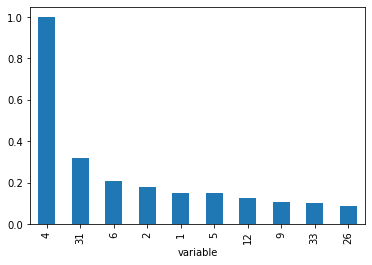

In [569]:
# Visual representation of the average importance of the difference variables

# fig, ax = plt.subplots()

# ax = plt.bar(importance.sort_values(by='Relative Importance', ascending=False)['Relative Importance'].head(10))
# plt.show()

importance.sort_values(by='Relative Importance', ascending=False)['Relative Importance'].head(10).plot(kind='bar')

In [543]:
importance_rank = list(range(1,37))
importance = importance.sort_values(by='Relative Importance', ascending=False)
importance['rank'] = importance_rank
importance.reset_index(inplace=True)

In [567]:
importance.head()

,variable,rf,gbt,avg,Relative Importance
variable,,,,,
1,1,0.054147,0.028359,0.041253,0.152153
2,2,0.039372,0.056408,0.047890,0.180152
3,3,0.014508,0.018439,0.016473,0.047624
4,4,0.125847,0.358637,0.242242,1.000000
5,5,0.067273,0.013380,0.040327,0.148246


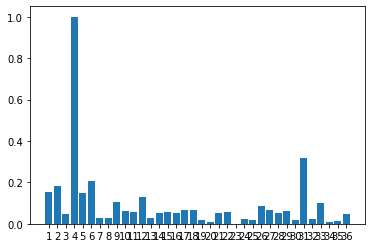

In [568]:
# importance.head(5)

importance.sort_values(by="Relative Importance", inplace=True)

fig, ax = plt.subplots()

ax.bar(x=importance.variable, height=importance['Relative Importance'], tick_label=importance.variable)
plt.show()

In [530]:
importance

,variable,rf,gbt,avg,Relative Importance,rank
0,4,0.125847,0.358637,0.242242,1.000000,1
1,31,0.041968,0.118906,0.080437,0.317447,2
2,6,0.072858,0.036481,0.054669,0.208749,3
3,2,0.039372,0.056408,0.047890,0.180152,4
4,1,0.054147,0.028359,0.041253,0.152153,5
5,5,0.067273,0.013380,0.040327,0.148246,6
6,12,0.052412,0.018471,0.035441,0.127638,7
7,9,0.035612,0.025589,0.030601,0.107218,8
8,33,0.028486,0.029101,0.028794,0.099596,9
9,26,0.025155,0.026325,0.025740,0.086714,10


### Testing final accuracy of model with selected best model

In [389]:
# Changes dataset into 0s and 1s depending on the value of the cell
X_test_zero_one = X_test.mask(data_of_interest > 0, 1).mask(data_of_interest <= 0, 0)

# Raw data accuracy = 0.9056603773584906
print(f'Raw data: {round(clf_scores[0][0].score(X_test,y_test),5)*100}% accuracy')

# Binary variables accuracy = 0.7358490566037735
print(f'Binary variables: {round(clf_scores[0][0].score(X_test_zero_one,y_test),5)*100}% accuracy')

# That seems like a pretty significant difference

Raw data: 90.566% accuracy
Binary variables: 73.585% accuracy


In [390]:
# I don't think the necessarily needs to be in the final product, but it helps evaluate the models.

from sklearn.metrics import classification_report

valid_pred = clf3.predict(X_valid)

print(classification_report(y_valid, valid_pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.75      0.82      0.78        11

    accuracy                           0.91        53
   macro avg       0.85      0.87      0.86        53
weighted avg       0.91      0.91      0.91        53



In [503]:
accuracy_dist = []

# Accuracy score for the true raw data
accuracy_dist.append(round(clf_scores[0][0].score(X_test,y_test),5)*100)

for i in range(10000):
    shuffled_target = y_test.sample(frac=1)
    accuracy_dist.append(round(clf_scores[0][0].score(X_test,shuffled_target),3)*100)

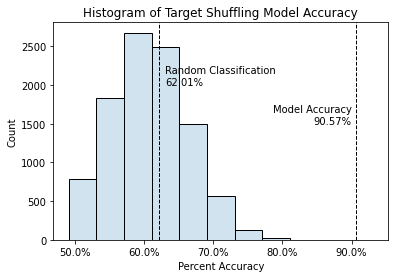

In [513]:
from matplotlib.ticker import PercentFormatter

fig, ax = plt.subplots()

ax = sn.histplot(accuracy_dist, binwidth=4, alpha=0.2)
plt.xlabel("Percent Accuracy")
plt.title("Histogram of Target Shuffling Model Accuracy")
ax.xaxis.set_major_formatter(PercentFormatter())
plt.axvline(90.566, linestyle='dashed', linewidth=1, color='k')
plt.text(90, 1500, f'Model Accuracy\n{round(accuracy_dist[0],2)}%', ha='right')
plt.axvline(62.2, linestyle='dashed', linewidth=1, color='k')
plt.text(63, 2000, f'Random Classification\n{round(np.mean(accuracy_dist[1:]),2)}%', ha='left')

plt.show()

In [511]:
np.mean(accuracy_dist[1:])

62.01373